In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

## Set up sky grid and information ##

In [2]:
nside = 128
# healpix indexes
hpid = np.arange(0, hp.nside2npix(nside))
# Ra/dec in degrees
ra, dec = hp.pix2ang(nside, hpid, lonlat=True)

In [3]:
# Get ecliptic and galactic coordinates
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
eclip_lat = coord.barycentrictrueecliptic.lat.deg
eclip_lon = coord.barycentrictrueecliptic.lon.deg
gal_lon = coord.galactic.l.deg
gal_lat = coord.galactic.b.deg

In [4]:
# Dustmap from sims_maps  - this is basically just a data directory
# The dustmap data is downloadable from https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/maps_may_2021.tgz
# (then just set SIMS_MAPS_DIR to where you downloaded it, after untarring the file)
def get_dustmap(nside=None):
    if nside is None:
        nside = set_default_nside()
    ebvDataDir = os.getenv('SIMS_MAPS_DIR')
    filename = 'DustMaps/dust_nside_%i.npz' % nside
    dustmap = np.load(os.path.join(ebvDataDir, filename))['ebvMap']
    return dustmap

In [5]:
# Get the dust extinction values at each healpix
dustmap = get_dustmap(nside)

/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In

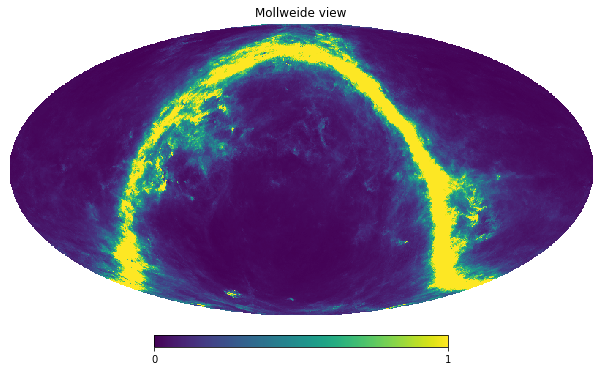

In [6]:
hp.mollview(dustmap, min=0, max=1)

## Estimate of survey time requirements ##

In [7]:
# How much survey time .. approximately .. is it likely to take to cover this area? 
# We can use a rough scaling derived from 
# https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb

# x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.76)  == constant (~1)
def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    defaults = {'survey_frac': 0.76, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']

In [8]:
scalingfunc(nvisits_per_pointing=870, survey_frac=None, area=18000)

0.8014545454545454

Text(0, 0.5, 'Survey fraction')

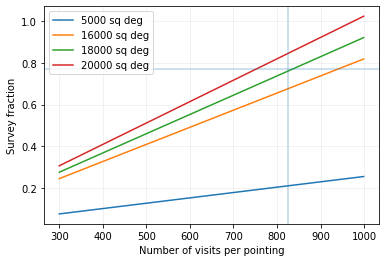

In [9]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.axhline(0.77, alpha=0.3)
plt.axvline(825, alpha=0.3)
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

## Low-dust extinction extragalactic

In [10]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
# These dec and dust limits are used to define the other survey areas as well. 
dust_limit = 0.2
dec_max = 8
dec_min = -67

exwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap < dust_limit), 1, 0)

/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In

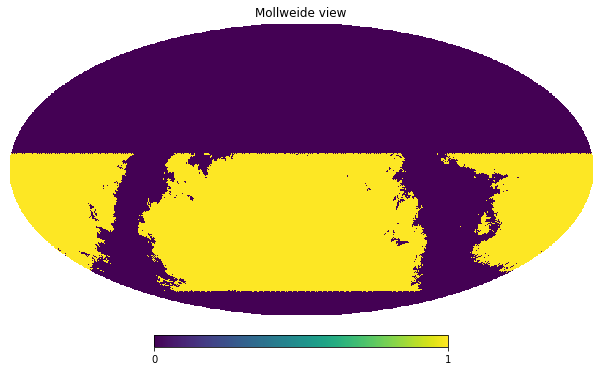

In [11]:
# Where is this on the sky?
hp.mollview(exwfd)

In [12]:
# how much area is covered? 
exgal_area = exwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in extragalactic wfd {exgal_area}')

Area in extragalactic wfd 16581.295078203115


In [13]:
# survey time required?
nvis_exgal = 825
t_exgal = scalingfunc(nvisits_per_pointing=nvis_exgal, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD, at {nvis_exgal} visits per pointing is {t_exgal}")
# But we have a desire to keep the number of visits per pointing higher to keep reserve in 'wfd' labelled area
nvis_exgal = int(825 * 1.08)
t_exgal = scalingfunc(nvisits_per_pointing=nvis_exgal, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD with {nvis_exgal} visits per pointing {t_exgal}")

Survey fraction required for extragalactic WFD, at 825 visits per pointing is 0.7000991255241314
Survey fraction required for extragalactic WFD with 891 visits per pointing 0.7561070555660621


## Galactic Plane ##

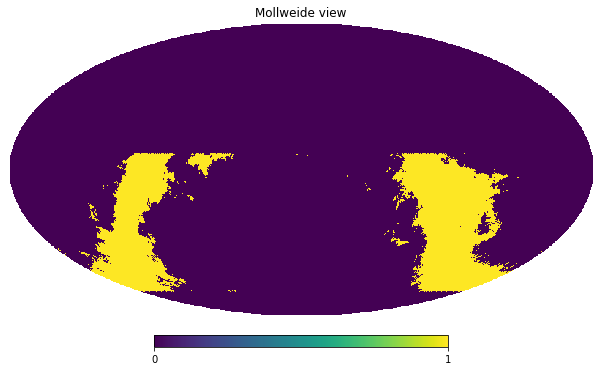

In [28]:
# Start with defining galactic plane zone as the entirety of the plane which was excluded by dust extinction above
galwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap > dust_limit), 1, 0)
hp.mollview(galwfd, max=1)

**RAS Modifications**

Rather than using the dust map to define the Galactic Plane region, we load here the areas reported by TVS/SMWLV to be of greatest scientific interest, and use this to estimate the required survey fraction.

In [22]:
footprint_maps_dir = os.getenv('FOOTPRINT_MAPS_DIR')
GP_footprint = hp.read_map(os.path.join(footprint_maps_dir,'GalPlane_priority_map_i.fits'))
healpix_priority_minimum_threshold = 0.5

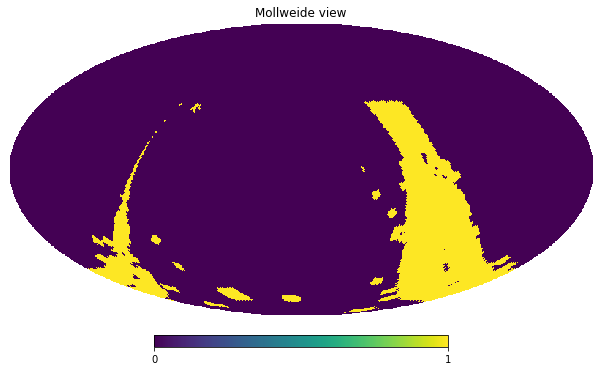

In [29]:
alt_galwfd = np.where(GP_footprint > healpix_priority_minimum_threshold,1,0)
hp.mollview(alt_galwfd, max=1)

In [30]:
# Compare how much area is covered? 
gp_area = galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in large galactic wfd {gp_area}')
gp_area_alt = alt_galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in alternative galactic wfd {gp_area_alt}')

Area in large galactic wfd 5252.92910196539
Area in alternative galactic wfd 1223.0606644839727


In [34]:
# Time required for original footprint?
nvis = 825
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for original galactic WFD, at {nvis} visits per pointing {t_gp}")
nvis = int(825*1.08)
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area)
print(f"Survey fraction required for original galactic WFD with {nvis} visits per pointing {t_gp}")

Survey fraction required for original galactic WFD, at 825 visits per pointing 0.2217903398607609
Survey fraction required for original galactic WFD with 891 visits per pointing 0.2395335670496218


In [33]:
# Time required for modified footprint?
nvis = 825
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area_alt)
print(f"Survey fraction required for prioritized galactic WFD, at {nvis} visits per pointing {t_gp}")
nvis = int(825*1.08)
t_gp = scalingfunc(nvisits_per_pointing=nvis, area=gp_area_alt)
print(f"Survey fraction required for prioritized galactic WFD with {nvis} visits per pointing {t_gp}")

Survey fraction required for prioritize galactic WFD, at 825 visits per pointing 0.051640339167101076
Survey fraction required for prioritize galactic WFD with 891 visits per pointing 0.05577156630046915


But the galactic plane has options - one being separating the plane into 'bulge' and 'the rest' or 'bulge', 'bridge' (a region at the opposite RA as the bulge) and 'the rest'.

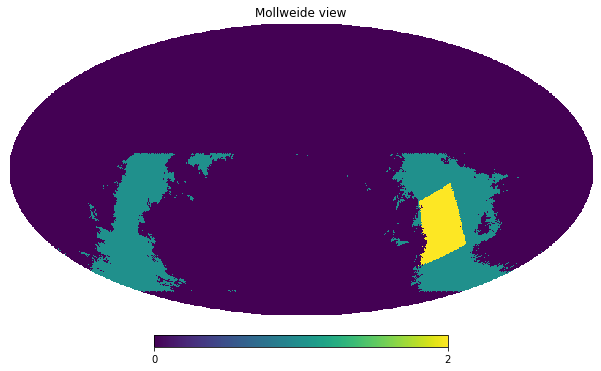

In [17]:
# Or if we reduce the number of visits to 300 over most of the plane and leave the bulge at 825
bulge_lon_span = 20
bulge_lat_span = 10
bulge = np.where(galwfd & 
                 (((gal_lon > (360-bulge_lon_span)) | (gal_lon < bulge_lon_span)) 
                  & (np.abs(gal_lat) < bulge_lat_span)), 1, 0)
gp_nobulge = galwfd - bulge
hp.mollview(bulge * 2 + gp_nobulge, min=0, max=2)

In [18]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_area = gp_nobulge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {gp_area} and non-bulge plane {gp_nobulge_area}')
nvis_bulge = 825
nvis_nobulge = 300
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_nobulge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_area)
print(f"Survey fraction required to cover the bulge to {nvis_bulge} visits per pointing\n",
      f" and the remainder of the plane to {nvis_nobulge} visits per pointing",
      f"{t_bulge + t_nobulge}")

Area in bulge 5252.92910196539 and non-bulge plane 4488.122767766715
Survey fraction required to cover the bulge to 825 visits per pointing
  and the remainder of the plane to 300 visits per pointing 0.10120037458541284


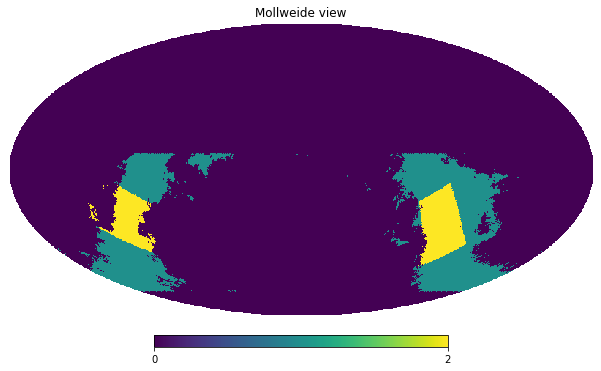

In [19]:
# And similar, but adding additional coverage at the 'bridge'
# Or if we reduce the number of visits to 300 over most of the plane and leave the bulge at 825
outer_bridge_l = 240
outer_bridge_lon_span = 15
outer_bridge_lat_span = 20 
bridge = np.where(galwfd & 
                  (((gal_lon < (outer_bridge_l + outer_bridge_lon_span))
                    & (gal_lon > (outer_bridge_l-outer_bridge_lon_span))
                    & (np.abs(gal_lat) < outer_bridge_lat_span))), 1, 0)
gp_nobulge_nobridge = galwfd - bulge - bridge
hp.mollview(bulge*2 + bridge*2 + gp_nobulge, max=2)

In [20]:
bulge_area = bulge.sum() * hp.nside2pixarea(nside, degrees=True)
bridge_area = bridge.sum() * hp.nside2pixarea(nside, degrees=True)
gp_nobulge_nobridge_area = gp_nobulge_nobridge.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in bulge {gp_area}, bridge {bridge_area}, and non-bulge plane {gp_nobulge_nobridge_area}')
nvis_bulge = 825
nvis_bridge = 825
nvis_nobulge = 300
t_bulge = scalingfunc(nvisits_per_pointing=nvis_bulge, area=bulge_area)
t_bridge = scalingfunc(nvisits_per_pointing=nvis_bridge, area=bridge_area)
t_nobulge_nobridge = scalingfunc(nvisits_per_pointing=nvis_nobulge, area=gp_nobulge_nobridge_area)
print(f"Survey fraction required to cover the bulge to {nvis_bulge} visits per pointing\n",
      f" the bridge to {nvis_bridge} visits per pointing\n",
      f" and the remainder of the plane to {nvis_nobulge} visits per pointing",
      f"{t_bulge + t_bridge + t_nobulge_nobridge}")

Area in bulge 5252.92910196539, bridge 520.781706853529, and non-bulge plane 3967.341060913185
Survey fraction required to cover the bulge to 825 visits per pointing
  the bridge to 825 visits per pointing
  and the remainder of the plane to 300 visits per pointing 0.11519309519380058


In [21]:
t_gal = t_bulge + t_bridge + t_nobulge_nobridge

## Ecliptic coverage ##

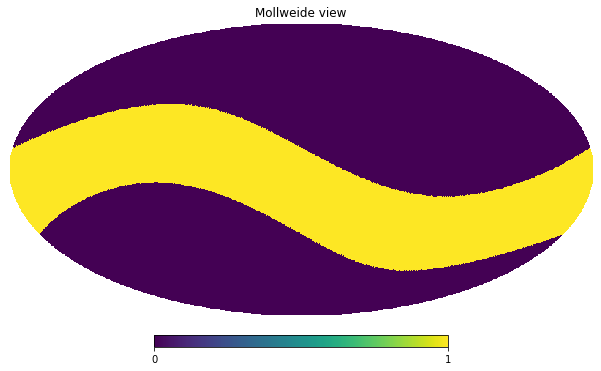

In [22]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -30
eclat_max = 10. 

ecplane = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max), 1, 0)

hp.mollview(ecplane, max=1)

In [23]:
# how much area is covered? 
ecplane_area = ecplane.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {ecplane_area}')

nvis_nes=450
t_ecliptic = scalingfunc(nvisits_per_pointing=nvis_nes, area=ecplane_area)
print(f"Survey fraction required for ecliptic plane, at {nvis_nes} visits per pointing {t_ecliptic}")

Area in ecliptic plane total 13897.0241774065
Survey fraction required for ecliptic plane, at 450 visits per pointing 0.3200526780251194


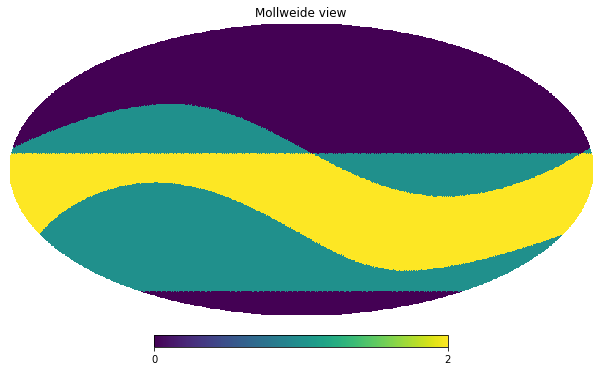

In [24]:
# But obviously some of this overlaps the remainder of the survey (although there may be different requirements)
hp.mollview(exwfd + galwfd + ecplane, max=2)

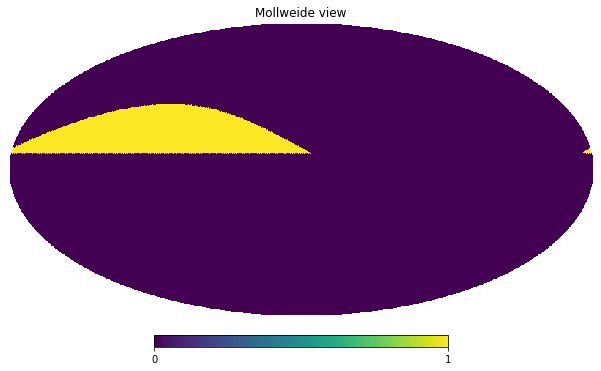

In [25]:
# So let's look at just the northern ecliptic spur part - where it's not potentially covered by other survey visits
nes = np.where((eclip_lat > eclat_min) & (eclip_lat < eclat_max) & (dec > dec_max), 1, 0)
hp.mollview(nes)

In [26]:
# how much area is covered? 
nes_area = nes.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {nes_area}')

nvis_nes=450
t_nes = scalingfunc(nvisits_per_pointing=nvis_nes, area=nes_area)
print(f"Survey fraction required for ecliptic plane, at {nvis_nes} visits per pointing {t_nes}")

Area in ecliptic plane total 3030.269706034918
Survey fraction required for ecliptic plane, at 450 visits per pointing 0.06978802959353143


## Magellanic Clouds ##

In [27]:
import numbers
def _angularSeparation(long1, lat1, long2, lat2):
    """
    Angular separation between two points in radians
    Parameters
    ----------
    long1 is the first longitudinal coordinate in radians
    lat1 is the first latitudinal coordinate in radians
    long2 is the second longitudinal coordinate in radians
    lat2 is the second latitudinal coordinate in radians
    Returns
    -------
    The angular separation between the two points in radians
    Calculated based on the haversine formula
    From http://en.wikipedia.org/wiki/Haversine_formula
    """
    t1 = np.sin(lat2/2.0 - lat1/2.0)**2
    t2 = np.cos(lat1)*np.cos(lat2)*np.sin(long2/2.0 - long1/2.0)**2
    _sum = t1 + t2

    if isinstance(_sum, numbers.Number):
        if _sum<0.0:
            _sum = 0.0
    else:
        _sum = np.where(_sum<0.0, 0.0, _sum)

    return 2.0*np.arcsin(np.sqrt(_sum))

In [28]:
def magellanic_clouds_healpixels(nside, lmc_radius=10, smc_radius=5):
    """
    Define the Magellanic clouds region. Return a healpix map with cloud pixels as 1.
    """
    # healpix indexes
    hpid = np.arange(0, hp.nside2npix(nside))
    # Ra/dec in degrees
    ra, dec = hp.pix2ang(nside, hpid, lonlat=True)
    ra = np.radians(ra)
    dec = np.radians(dec)
    result = np.zeros(hp.nside2npix(nside))

    lmc_ra = np.radians(80.893860)
    lmc_dec = np.radians(-69.756126)
    lmc_radius = np.radians(lmc_radius)

    smc_ra = np.radians(13.186588)
    smc_dec = np.radians(-72.828599)
    smc_radius = np.radians(smc_radius)

    dist_to_lmc = _angularSeparation(lmc_ra, lmc_dec, ra, dec)
    lmc_pix = np.where(dist_to_lmc < lmc_radius)
    result[lmc_pix] = 1

    dist_to_smc = _angularSeparation(smc_ra, smc_dec, ra, dec)
    smc_pix = np.where(dist_to_smc < smc_radius)
    result[smc_pix] = 1
    return result

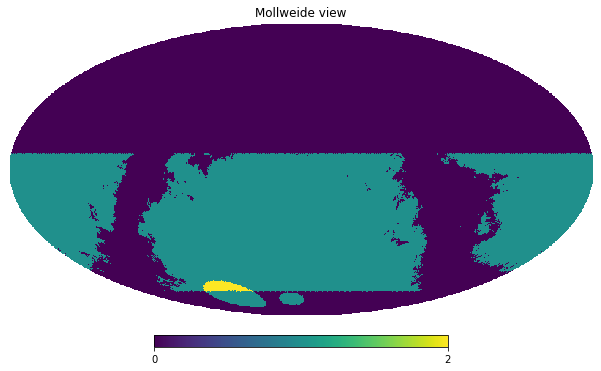

In [29]:
# So this shows us the magellanic clouds, but they do overlap with WFD
mag_clouds = magellanic_clouds_healpixels(nside)
hp.mollview(mag_clouds + exwfd, max=2)

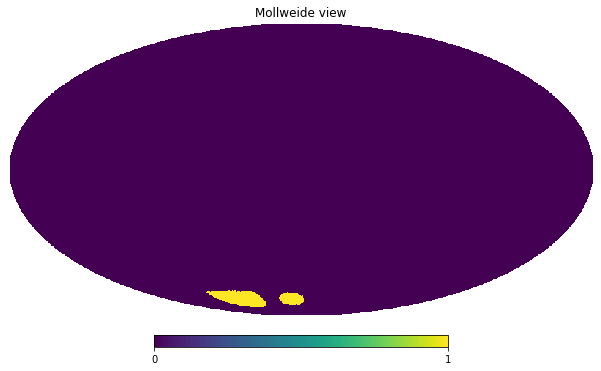

In [30]:
# If we want to just include the area outside the extraglactic WFD - assume WFD is good enough
mag_clouds = np.where((mag_clouds==1) & (exwfd==0), 1, 0)
hp.mollview(mag_clouds, max=1)

In [31]:
# how much area is covered? 
mag_area = mag_clouds.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in magellanic clouds total {mag_area}')

nvis_mag=825
t_mag = scalingfunc(nvisits_per_pointing=nvis_mag, area=mag_area)
print(f"Survey fraction required for magellanic clouds, at {nvis_mag} visits per pointing {t_mag}")

Area in magellanic clouds total 278.2258433875018
Survey fraction required for magellanic clouds, at 825 visits per pointing 0.0117473133874723


## Southern Celestial Pole ##

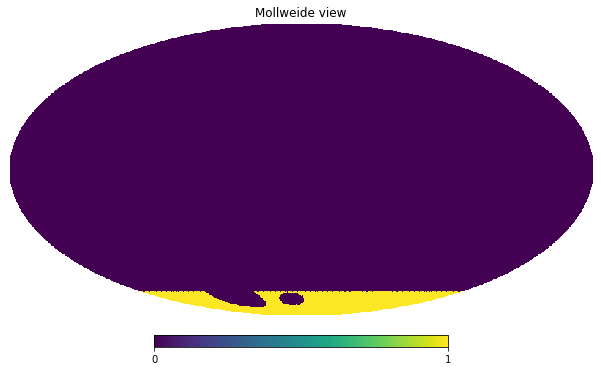

In [32]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
scp = np.where((dec < dec_min) & (mag_clouds == 0), 1, 0)
hp.mollview(scp)

In [33]:
scp_area = scp.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in southern celestial pole {scp_area}')

nvis_scp = 200
t_scp = scalingfunc(nvisits_per_pointing=nvis_scp, area=scp_area)
print(f"Survey fraction required for magellanic clouds, at {nvis_scp} visits per pointing {t_scp}")

Area in southern celestial pole 1364.0619968794488
Survey fraction required for magellanic clouds, at 200 visits per pointing 0.013962116062335097


## Total ##

In [34]:
# We need at least 5% of the time for DDFs
t_ddf = 0.05
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03

In [35]:
# Modify this as needed .. for example, if changing galactic plane structure
surveyfootprint = (nvis_exgal * exwfd 
                   + nvis_bulge * bulge + nvis_bridge * bridge
                   + nvis_nobulge * gp_nobulge_nobridge
                   + nvis_mag * mag_clouds
                   + nvis_nes * nes 
                   + nvis_scp * scp)

In [36]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
goal_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= int(825 * 1.08))[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least 825 visits per pointing {goal_srd}")
print(f"Area covered to at least 825 visits PLUS 8% reserve {res_srd}")

Area covered to at least 825 visits per pointing 18145.108962642822
Area covered to at least 825 visits PLUS 8% reserve 16584.442429372655


,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,16581.295078,0.756107,891.0
Bulge/Bridge,1285.588041,0.054280,825.0
Galactic,3967.341061,0.060913,300.0
NES,3030.269706,0.069788,450.0
MCs,278.225843,0.011747,825.0
SCP,1364.061997,0.013962,200.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.030000,NaN


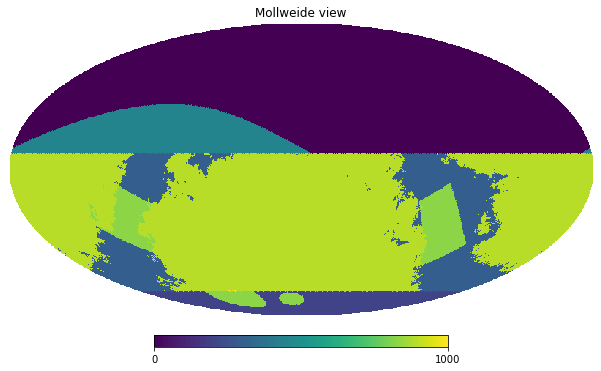

In [37]:
hp.mollview(surveyfootprint, min=0, max=1000)
pd.DataFrame([[exgal_area, t_exgal, nvis_exgal], 
              [bulge_area + bridge_area, t_bulge + t_bridge, nvis_bulge],
              [gp_nobulge_nobridge_area, t_nobulge_nobridge, nvis_nobulge],
              [nes_area, t_nes, nvis_nes], 
              [mag_area, t_mag, nvis_mag], 
              [scp_area, t_scp, nvis_scp], 
              [t_ddf/.01 * 9.6, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "Bulge/Bridge", "Galactic", "NES", "MCs", "SCP", "DDF", "Mini"])

In [38]:
t_total = t_exgal + t_gal + t_nes + t_mag + t_scp
t_total += t_ddf + t_mini
print(f"Total time required {t_total}")

Total time required 1.0467976098032015
